<a href="https://colab.research.google.com/github/CNU-Jiho-Jeong/Data-analysis-lecture/blob/main/Natural_Langague_Processing_with_Moview_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (18.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [2]:
%pip install konlpy wordcloud 
# konlpy: 한국어 정보처리를 위한 파이썬 패키지
# wordcloud: 단어의 빈도수를 체크하여 시각적으로 표현하는 방식

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 465 kB 11.3 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re # re: 정규표현 처리를 위한 라이브러리 
import urllib.request # urlib.request: URL을 여는데 도움이 되는 함수와 클래스를 정의
from konlpy.tag import Okt # Okt: Open Korean Text, 형태소 분석기
from tqdm import tqdm # tqdm: 작업진행률 표시
from tensorflow.keras.preprocessing.text import Tokenizer # 토큰화를 위해 Tokenizer import
from tensorflow.keras.preprocessing.sequence import pad_sequences # 패딩을 위해 pad_sequences import

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 글꼴 경로 / 글꼴: 나눔고딕

In [4]:
plt.rc("font", family = "NanumBarunGothic")
# rc 함수를 이용해 글꼴 설정을 바꿀 수 있음. / 위의 경우는 나눔바른고딕 
# plt.rc("font", family="글꼴이름")


In [5]:
# 데이터 다운받기

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f6361ffb130>)

In [6]:
# 데이터 불러오기

train_data = pd.read_table("ratings_train.txt")
test_data = pd.read_table("ratings_test.txt")

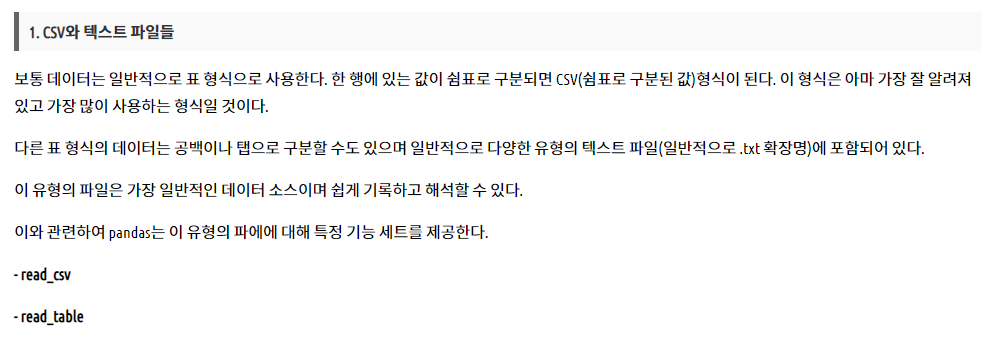

출처: https://cyan91.tistory.com/22

In [7]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [8]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
# 데이터 비율 파악하기 (0은 몇 개, 1은 몇 개)

train_data.groupby(["label"]).count()

,id,document
label,,
0,75173,75170
1,74827,74825


In [10]:
test_data.groupby(["label"]).count()

,id,document
label,,
0,24827,24826
1,25173,25171


In [11]:
# 데이터 갯수 줄이기

train_data = train_data[0:15000]
test_data = test_data[0:5000]

In [12]:
# document 열과 label 열의 중복을 제외한 값의 갯수

train_data["document"].nunique(), train_data["label"].nunique()

(14833, 2)

In [13]:
# document 열의 중복제거

train_data.drop_duplicates(subset=["document"], inplace=True)
print("총 댓글의 갯수 :", len(train_data))
# 14833이 나와야 함

총 댓글의 갯수 : 14833


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


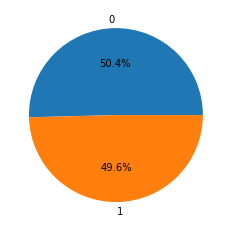

In [14]:
# 긍정 리뷰와 부정 리뷰 비율 시각화

ratio = train_data['label'].value_counts() 
# value_counts(): 어떤 칼럼/series의 unique value들을 count 해주는 함수
label = ratio.index # 0, 그러니까 부정의 인덱스는 0 / 1, 그러니까 긍정의 인덱스는 1
plt.pie(ratio, labels=label, autopct="%.1f%%")
plt.show()


In [15]:
# 결측값 여부 판단

train_data.isnull().values.any()
# isnull().values.any() -> NaN 값이 하나라도 존재하는지 true 혹은 false로 알려준다.


False

=> 어느 열에도 결측값이 없다

In [17]:
# 특정 단어를 변경하기

s1 = "ㅋㅋㅋㅋㅋ 아 이거 존잼"
s2 = "아 진짜 개 피곤하다....."
s3 = "저녁 드셨나요??"

test = pd.Series([s1,s2,s3])
test = test.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test.str.replace("^[ㄱ-ㅎ]+", "") 

# => 한글과 공백을 제외하고 모두 제거.


<ipython-input-17-226ae3238bf5>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  test = test.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-17-226ae3238bf5>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  test.str.replace("^[ㄱ-ㅎ]+", "")


0        아 이거 존잼
1    아 진짜 개 피곤하다
2        저녁 드셨나요
dtype: object

In [18]:
# 한글과 공백을 제외하고 모두 제거.

train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'] = train_data['document'].str.replace("^[ㄱ-ㅎ]+", "")
train_data.head()

<ipython-input-18-5586979fdada>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-18-5586979fdada>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("^[ㄱ-ㅎ]+", "")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [19]:
# 빈 공간이 생기지 않을까? -> 결측값이 만들어졌을까?

train_data["document"] = train_data["document"].str.replace('^ +',"")
train_data['document'].replace('', np.nan, inplace = True) # 빈 공간을 nan으로
print(train_data.isnull().sum())

id            0
document    107
label         0
dtype: int64


<ipython-input-19-5b1122e0ef76>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data["document"] = train_data["document"].str.replace('^ +',"")


In [21]:
# 실제로 확인

train_data.loc[train_data.document.isnull()].head()

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [22]:
# 결측치 제거

train_data.dropna(how="any", inplace=True) # how="any" -> 행에 결측치가 하나라도 있으면 날리기
print(len(train_data))

14726


In [23]:
# test data 도 동일한 과정으로 정제!

test_data.drop_duplicates(subset = ['document'], inplace = True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace("^[ㄱ-ㅎ]+", "")
test_data['document'] = test_data['document'].str.replace('^ +',"")
test_data['document'].replace('', np.nan, inplace = True)
test_data.dropna(how = 'any', inplace = True)
print(len(test_data))

4913


<ipython-input-23-7629a8a05c3d>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-23-7629a8a05c3d>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("^[ㄱ-ㅎ]+", "")
<ipython-input-23-7629a8a05c3d>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +',"")


In [24]:
# 불용어 정의

stopwords = ['의', '가', '는', '은', '들', '는', '를', '으로']

In [25]:
# 형태소 분석

okt = Okt()
okt.morphs('아 배고파 붕어빵 먹고싶다... 빨리')

['아', '배고파', '붕어빵', '먹고싶다', '...', '빨리']

In [26]:
okt.morphs('아 배고파 붕어빵 먹고싶다... 빨리', stem = True)

['아', '배고프다', '붕어빵', '먹다', '...', '빨리']

norm옵션 : 그래욬ㅋㅋ -> 그래요 처럼 변환해주는 옵션

stem옵션 : 원형을 찾아주는 옵션 (그래요 -> 그렇다)

In [27]:
# tqdm : 작업의 진행상황을 시각화 해준다.
# 모든 댓글을 형태소로 나누기

X_train = []
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem = True) #형태소 분석
  stopwords_removed_token = [word for word in tokenized_sentence if not word in stopwords] #불용어 제거
  X_train.append(stopwords_removed_token)

100%|██████████| 14726/14726 [01:03<00:00, 231.85it/s]


In [28]:
X_test = []
for sentence in tqdm(test_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem = True) #형태소 분석
  stopwords_removed_token = [word for word in tokenized_sentence if not word in stopwords] #불용어 제거
  X_test.append(stopwords_removed_token)

100%|██████████| 4913/4913 [00:19<00:00, 251.02it/s]


In [29]:
train_data.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [30]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '한', '다']]

In [31]:
# 모든 단어를 토큰화 한다.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [32]:
print(tokenizer.word_index)

{'이': 1, '영화': 2, '보다': 3, '하다': 4, '에': 5, '을': 6, '도': 7, '없다': 8, '이다': 9, '있다': 10, '좋다': 11, '너무': 12, '다': 13, '한': 14, '정말': 15, '만': 16, '재밌다': 17, '적': 18, '되다': 19, '같다': 20, '진짜': 21, '로': 22, '아니다': 23, '점': 24, '않다': 25, '에서': 26, '만들다': 27, '연기': 28, '과': 29, '나오다': 30, '평점': 31, '것': 32, '최고': 33, '안': 34, '인': 35, '내': 36, '나': 37, '못': 38, '그': 39, '스토리': 40, '왜': 41, '드라마': 42, '생각': 43, '사람': 44, '감동': 45, '보고': 46, '이렇다': 47, '게': 48, '고': 49, '아깝다': 50, '때': 51, '감독': 52, '더': 53, '말': 54, '그냥': 55, '재미': 56, '배우': 57, 'ㅋㅋ': 58, '시간': 59, '와': 60, '거': 61, '아': 62, '재미없다': 63, '요': 64, '재미있다': 65, '까지': 66, '내용': 67, '하고': 68, '자다': 69, '지루하다': 70, '중': 71, '뭐': 72, '주다': 73, '네': 74, '가다': 75, '쓰레기': 76, '좀': 77, '모르다': 78, '작품': 79, '수': 80, '지': 81, '들다': 82, '알다': 83, '싶다': 84, '하나': 85, '사랑': 86, '그렇다': 87, '정도': 88, '이건': 89, '볼': 90, '다시': 91, '잘': 92, '이렇게': 93, '액션': 94, 'ㅠㅠ': 95, '마지막': 96, '저': 97, '차다': 98, '처음': 99, '완전': 100, 'ㅋ': 101, '개': 102, '최악':

In [33]:
# 사용된 단어의 수

len(tokenizer.word_index)

15053

In [34]:
# 상위 10개 단어?

word_freq = sorted(tokenizer.word_counts.items(), 
                   key = lambda item: item[1], reverse = True) # 내림차순으로 정렬
word_freq[0:10]

[('이', 5639),
 ('영화', 5074),
 ('보다', 4113),
 ('하다', 4058),
 ('에', 2688),
 ('을', 2434),
 ('도', 2230),
 ('없다', 1632),
 ('이다', 1355),
 ('있다', 1223)]

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48372 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_

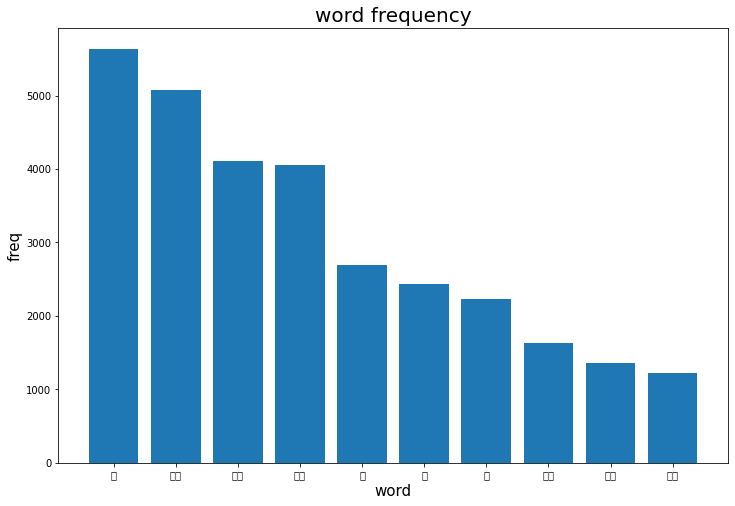

In [35]:
word_freq_10 = dict(word_freq[0:10])

word = word_freq_10.keys()
freq = word_freq_10.values()

plt.figure(figsize = (12,8))
plt.bar(word, freq)
plt.title("word frequency", fontsize = 20)
plt.xlabel("word", fontsize = 15)
plt.ylabel("freq", fontsize = 15)
plt.show()


In [36]:
# 등장단어의 빈도 추려내기.

threshold = 3
total_cnt = len(tokenizer.word_index) # 총 단어의 갯수

rare_cnt = 0 # 등장 빈도수가 threshold 보다 작은 단어의 갯수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold 보다 작은 단어의 등장 빈도수의 총 합

for key, value in tokenizer.word_counts.items():
  total_freq += value   # 종복을 허용하여 사용된 단어의 총 갯수

  if(value < threshold):
    rare_cnt += 1
    rare_freq += value

print('단어 집합의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율 : {:1.2f}%".format(rare_cnt/total_cnt * 100))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : {:1.2f}%".format(rare_freq / total_freq * 100))

단어 집합의 크기 : 15053
등장 빈도가 2번 이하인 희귀 단어의 수: 9608
단어 집합에서 희귀 단어의 비율 : 63.83%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 6.59%


### 등장빈도가 2번 이하인 단어들이 전체중에 64%정도...
### 근데 이런 단어들이 전체에서 6.5%밖에 사용이 안됨!
### 즉 이런 단어들은 학습에 있어서 노이즈다.

In [37]:
vocab_size = total_cnt - rare_cnt + 1
print("의미있는 단어 집합 크기 :", vocab_size)

의미있는 단어 집합 크기 : 5446


In [38]:
# 의미 있는 단어들도 다시 토큰화 하기

tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)

In [39]:
# 문장을 숫자로 바꾼다. (벡터화 하기)

X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

In [40]:
X_train[:2]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다']]

In [41]:
X_train_encoded[:2]

[[62, 571, 21, 288, 819], [725, 371, 46, 621, 2, 174, 1554, 28, 868, 694, 25]]

In [42]:
# y 데이터 정의

y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [43]:
# 빈 문장들 제거
# 문장의 길이가 0이면 빈 문장..!

drop_train = [index for index, sentence in enumerate(X_train_encoded) if len(sentence) < 1]
# drop_train

In [44]:
X_train_encoded = np.delete(X_train_encoded, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)

print(len(X_train_encoded))
print(len(y_train))

14674
14674


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [45]:
review_len = [len(review) for review in X_train_encoded]

print("리뷰의 최대 길이 : {}".format(max(review_len)))
print("리뷰의 평균 길이 : {}".format(sum(review_len) / len(review_len)))

리뷰의 최대 길이 : 63
리뷰의 평균 길이 : 11.399141338421698


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48624 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_

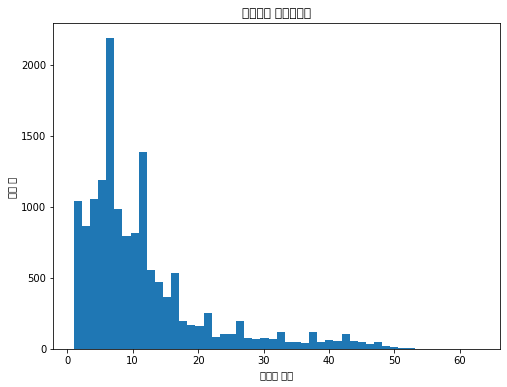

In [46]:
# 리뷰길이의 히스토그램?

plt.figure(figsize = (8,6))
plt.hist([len(review) for review in X_train_encoded], bins = 50)
plt.title("리뷰길이 히스토그램")
plt.xlabel("단어의 길이")
plt.ylabel("빈도 수 ")
plt.show()

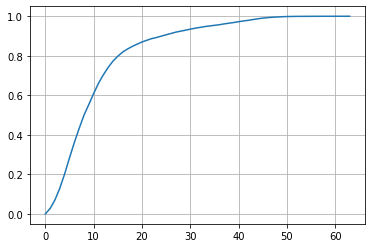

In [47]:
# 리뷰의 길이가 적을수록 학습하는데 걸리는 시간은 감소한다. 
# 누적 분포도를 구해보자.

review_len_cum = []

for num in range(max(review_len) + 1):
  review_len_cum.append(len([n for n in review_len if n <= num]) / len(review_len))

plt.plot(review_len_cum)
plt.grid()
plt.show()

In [48]:
# 리뷰길이가 40개 이하인 리뷰들은 전체에서 95%정도 되니까 최대길이를 40으로 설정하자.
# padding 하기.

max_len = 40
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)

In [49]:
X_train_padded[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   62,  571,   21,  288,  819],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  725,  371,   46,  621,
           2,  174, 1554,   28,  868,  694,   25]], dtype=int32)

In [50]:
# LSTM 모델 학습

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [51]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation = 'sigmoid'))


In [52]:
# 검증 데이터 손실(val_loss)가 증가하면 과적합 징후이므로 
# 검증 데이터 손실이 4회 증가하면 정해진 epoch가 도달하지 못하여도
# 학습을 조기종료 시킨다.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에는 모델을 저장
mc = ModelCheckpoint('best_model.h1', monitor = 'val_acc', mode = 'max', verbose = 1,
                     save_best_only = True)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train_padded, y_train, epochs = 15, callbacks = [es, mc],
                    batch_size = 64, validation_split = 0.2)

Epoch 1/15
184/184 [==============================] - ETA: 0s - loss: 0.5107 - acc: 0.7487
Epoch 1: val_acc improved from -inf to 0.78535, saving model to best_model.h1


184/184 [==============================] - 34s 159ms/step - loss: 0.5107 - acc: 0.7487 - val_loss: 0.4391 - val_acc: 0.7853
Epoch 2/15
184/184 [==============================] - ETA: 0s - loss: 0.3521 - acc: 0.8462
Epoch 2: val_acc improved from 0.78535 to 0.81295, saving model to best_model.h1


184/184 [==============================] - 26s 144ms/step - loss: 0.3521 - acc: 0.8462 - val_loss: 0.4056 - val_acc: 0.8129
Epoch 3/15
184/184 [==============================] - ETA: 0s - loss: 0.3087 - acc: 0.8699
Epoch 3: val_acc did not improve from 0.81295
184/184 [==============================] - 20s 111ms/step - loss: 0.3087 - acc: 0.8699 - val_loss: 0.4436 - val_acc: 0.8034
Epoch 4/15
184/184 [==============================] - ETA: 0s - loss: 0.2846 - acc: 0.8818
Epoch 4: val_acc did not improve from 0.81295
184/184 [==============================] - 23s 124ms/step - loss: 0.2846 - acc: 0.8818 - val_loss: 0.4217 - val_acc: 0.8075
Epoch 5/15
184/184 [==============================] - ETA: 0s - loss: 0.2667 - acc: 0.8898
Epoch 5: val_acc did not improve from 0.81295
184/184 [==============================] - 20s 110ms/step - loss: 0.2667 - acc: 0.8898 - val_loss: 0.4331 - val_acc: 0.8065
Epoch 6/15
184/184 [==============================] - ETA: 0s - loss: 0.2536 - acc: 0.8962
Ep

In [53]:
loaded_model = load_model('best_model.h1')

In [54]:
print("테스트 정확도 : {:1.4f}%".format(loaded_model.evaluate(X_test_padded, y_test)[1] * 100)) # 테스트 데이터로 정확도를 판단한다

154/154 [==============================] - 5s 25ms/step - loss: 0.3973 - acc: 0.8256
테스트 정확도 : 82.5565%


In [55]:
def predict_review(sentence):
  sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]',"",sentence)
  sentence = re.sub(r'^[ㄱ-ㅎ]+','',sentence)
  sentence = okt.morphs(sentence, stem = True)
  sentence = [word for word in sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([sentence])
  pad = pad_sequences(encoded, maxlen = max_len)
  score = float(loaded_model.predict(pad))

  if (score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1-score) * 100))

In [56]:
predict_review("아 이 영화 진짜 재밌음ㅋㅋㅋㅋㅋㅋㅋ")

1/1 [==============================] - 1s 688ms/step
94.40% 확률로 긍정 리뷰입니다.



In [57]:
predict_review("애매한데?")

1/1 [==============================] - 0s 24ms/step
65.50% 확률로 부정 리뷰입니다.

